# What is data augumentation?

Data augumentation is where you use random transformations on your input data. For example if you flip your input images upside down.

References:
- example of data augumentation increasing accuracy https://github.com/robertomest/convnet-study
- ImageDataGenerator in keras https://keras.io/preprocessing/image/

## The problem

Let's load a classic VGG model and test it out again adverserial examples that could appear during real world usage.

In [1]:
%pylab --no-import-all inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.sys.path.append(os.path.abspath('.'))

In [3]:
import keras
import keras.models
from keras.datasets import cifar10
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
# init
K.set_image_data_format('channels_last')
seed=0
batch_size = 32

# Model

We load a small 40 layer [densenet model](https://arxiv.org/abs/1608.06993) which has been pretrained on the [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. With only 1M params it got 95% accuracy.

The pretrained model was provided by [robertomest](https://github.com/robertomest/convnet-study/issues/1). Thanks robert.

Densenet is charecterised by skip connects between all layers. 

![densenet](https://github.com/titu1994/DenseNet/raw/master/images/dense_net.JPG?raw=true)

As of 25 Aug 2016 it beat all previous benchmarks in CIFAR 10, CIFAR 100 and SVHN.

![](https://github.com/titu1994/DenseNet/raw/master/images/accuracy_densenet.JPG?raw=true)


In [5]:
# load a pretrained densenet model from https://github.com/robertomest/convnet-study
model = keras.models.model_from_json(
    open('pretrained_models/densenet_cifar10_robertomest/densenet.json')
    .read())
model.load_weights(
    './pretrained_models/densenet_cifar10_robertomest/densenet.h5')

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/media/isisilon/Data/My_Documents/Documents/eclipse-workspace/keras/keras/engine/topology.py:1237: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_313 (Conv2D)              (None, 32, 32, 16)    432         input_9[0][0]                    
____________________________________________________________________________________________________
batch_normalization_313 (BatchNo (None, 32, 32, 16)    64          conv2d_313[0][0]                 
____________________________________________________________________________________________________
activation_321 (Activation)      (None, 32, 32, 16)    0           batch_normalization_313[0][0]    
___________________________________________________________________________________________

# Dataset

cifar10

![cifar10](https://kaggle2.blob.core.windows.net/competitions/kaggle/3649/media/cifar-10.png)

In [6]:
# From https://github.com/robertomest/convnet-study/blob/master/rme/datasets/cifar10.py#L104
# Apply preprocessing as described in the paper: normalize each channel
# individually. We use the values from fb.resnet.torch, but computing the values
# gets a very close answer.
def preprocess_data(data_set):
    mean = np.array([125.3, 123.0, 113.9])
    std = np.array([63.0, 62.1, 66.7])

    data_set = data_set.astype(np.float32)
    data_set -= mean
    data_set /= std
    return data_set

def unpreprocess_data(data_set):
    mean = np.array([125.3, 123.0, 113.9])
    std = np.array([63.0, 62.1, 66.7])

    data_set *= std
    data_set += mean
    
    return data_set.astype(np.uint8)


In [7]:
# Load cifar10 data from keras' datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

y_test = keras.utils.to_categorical(y_test)
y_train = keras.utils.to_categorical(y_train)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.2, random_state=seed)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3),
 (50000, 10),
 (2000, 32, 32, 3),
 (2000, 10),
 (8000, 32, 32, 3),
 (8000, 10))

In [8]:
# load labels
import pickle
from keras.utils.data_utils import get_file
path = get_file(
    'cifar-10-batches-py',
    origin='http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
    untar=True)
cifar10_meta = pickle.load(open(os.path.join(path, 'batches.meta'), 'rb'))
label_names = cifar10_meta["label_names"]
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Normal performance

How is the accuracy with no augumentation?

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid


def plot_predictions(X, y, y_pred, title=None):
    """Plot a grid of labelled predictions."""

    figure = plt.figure(figsize=(10, 10))
    grid = ImageGrid(figure, 111, (5, 5), axes_pad=0.3)
    X_raw = unpreprocess_data(X * 1.0)

    for i, axis in enumerate(grid):

        axis.imshow(X_raw[i], interpolation='nearest')

        axis.set_yticklabels([])
        axis.set_xticklabels([])
        axis.axis('off')

        is_correct = y[i].argmax() == y_pred[i].argmax()
        txt = '{} {} {:2.2%}'.format('✓' if is_correct else 'x',
                                     label_names[y_pred[i].argmax()][:5],
                                     y_pred[i].max())
        axis.text(
            0.0,
            32+3.5,
            txt,
            size=12,
#             backgroundcolor='gray',
            color='black' if is_correct else 'red')

    if title:
        figure.suptitle(title, x=0.5, y=0.93, fontsize=16)
    plt.show()

# X,y=next(val_gen)
# plot_predictions(X,y,y/2+np.random.random(y.shape),'test')

In [10]:
from keras.preprocessing.image import ImageDataGenerator


def test_augumentations(**aug_args):
    """Plot and test model accuracy for differen't input data agumentations."""

    datagen = ImageDataGenerator(**aug_args)
    steps = 50

    datagen.fit(X_val, seed=seed)
    val_gen = datagen.flow(X_val, y_val, batch_size=batch_size, seed=seed)

    score = model.evaluate_generator(val_gen, steps=steps)
    score = dict(zip(model.metrics_names, score))
    
    X, y = next(val_gen)
    y_pred = model.predict(X)
    plot_predictions(X, y, y_pred, title='acc {:2.4%} [n={}]'.format(score['acc'], val_gen.batch_size * steps))

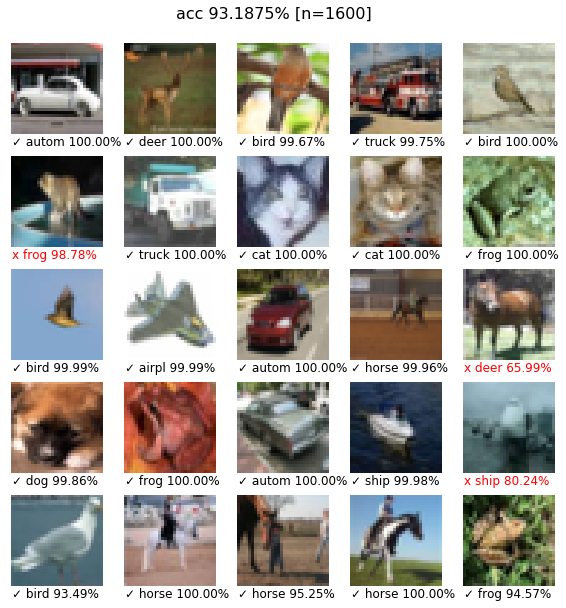

In [11]:
test_augumentations()

# What if we flip the images?

Our accuracy went from 93% to 70%! You don't want to see this drop when you
test your model on real world data.

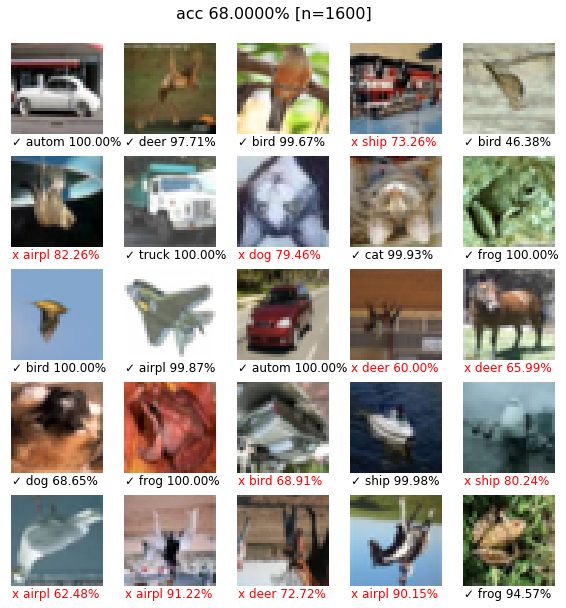

In [12]:
test_augumentations(
    horizontal_flip=True,
    vertical_flip=True
)

# What about other transforms?

This is fairly resistant to random noise being added, more so than my brain. I wonder why that is?

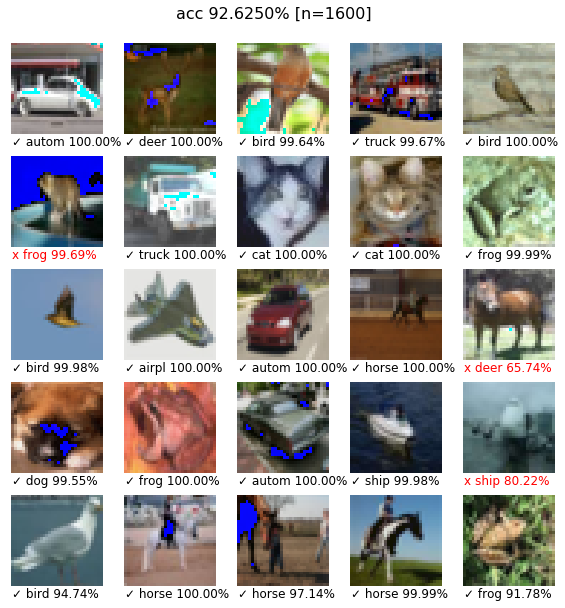

In [13]:
# random noise
test_augumentations(
    channel_shift_range=0.5
)

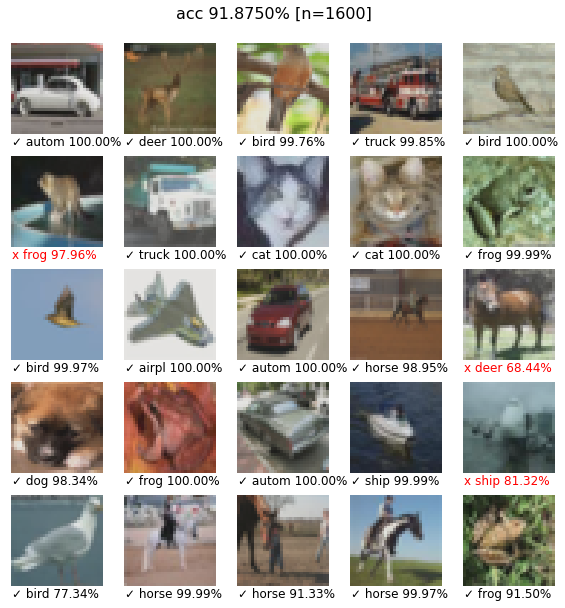

In [14]:
# change the brightness a bit
test_augumentations(
    rescale=0.8
)

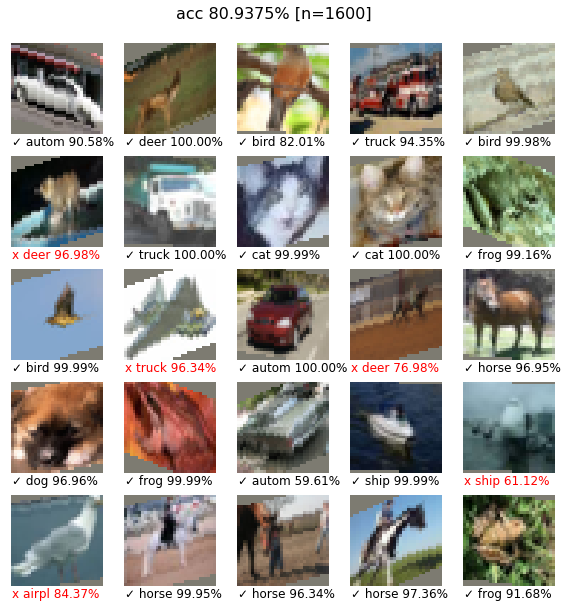

In [15]:
test_augumentations(
    shear_range=0.5,
    fill_mode='constant',
)

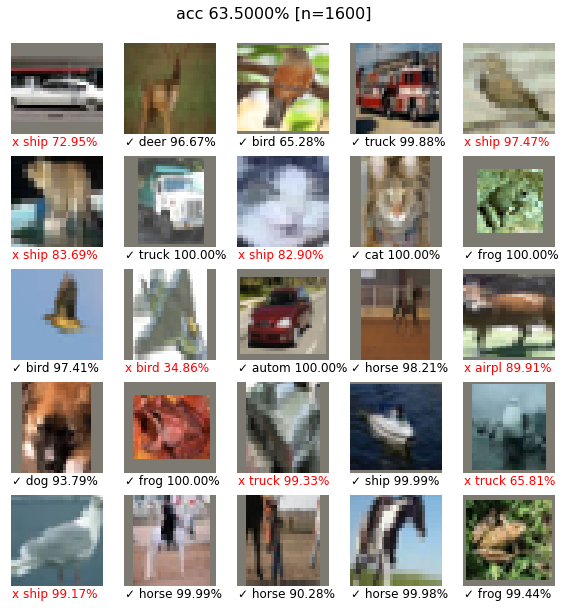

In [16]:
test_augumentations(
    zoom_range=0.5,
    fill_mode='constant',
)

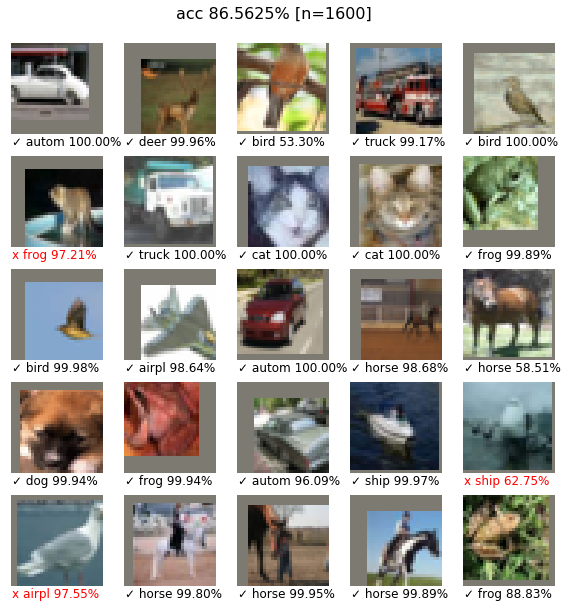

In [17]:
test_augumentations(
    height_shift_range=0.2,
    width_shift_range=0.2,
    fill_mode='constant',
)

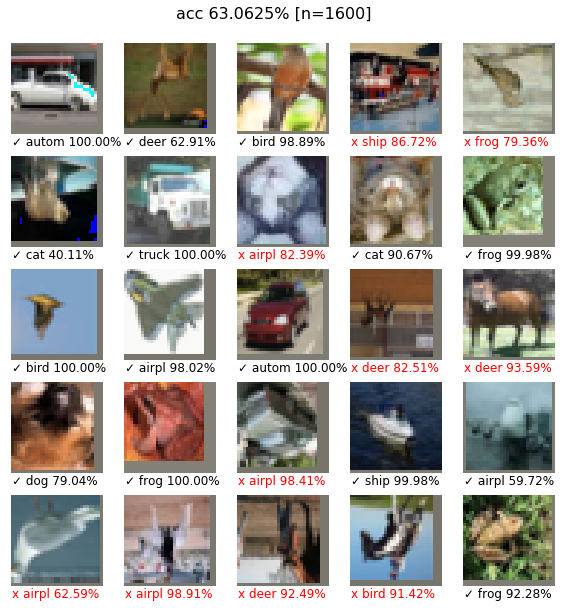

In [18]:
# Bring them all together
test_augumentations(
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    channel_shift_range=0.1,
    fill_mode='constant',
)

# Solution

So lots of state of the art models fail when confronted with upside down, resized, etc images. In fact sometimes adding a tiny bit of random noise can fool it (adverserial examples).

But we can train away this weakness, making our models more resilient in real world cases. 

It will also increase out final accuray on the test set. In [the convnet-study](https://github.com/robertomest/convnet-study) repository, they got an ccuracy of **93.58%** without data augmentation and **94.72%** with horizontal flips and crops. That could move you up the kaggle leaderboard a bit!


In [19]:
# Nicer progressbar
from keras_tqdm import TQDMNotebookCallback

In [20]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
#     height_shift_range=0.1,
#     width_shift_range=0.1,
#     fill_mode='constant',
)

datagen.fit(X_val, seed=seed)
val_gen = datagen.flow(X_val, y_val, batch_size=batch_size, seed=seed)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size, seed=seed)

In [21]:
# Completely uneeded I just wanted to show you a cool thing
class PredictPlot(keras.callbacks.Callback):
    """Callback to plot predictions after each epoch."""
    def __init__(self, X_val, y_val, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.X_val = X_val
        self.y_val = y_val
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(
            self.X_val,
            verbose=False
        )
        plot_predictions(self.X_val, self.y_val, y_pred)
            


# test
X_val, y_val = next(val_gen)
# predict_plot = PredictPlot(X_val, y_val)
# predict_plot.model = model
# predict_plot.on_epoch_end(0)

In [ ]:
from keras_tqdm import TQDMNotebookCallback
from keras_tqdm import TQDMCallback

Epoch 1/300
1562/1562 [============================>.] - ETA: 0s - loss: 0.7654 - acc: 0.7838

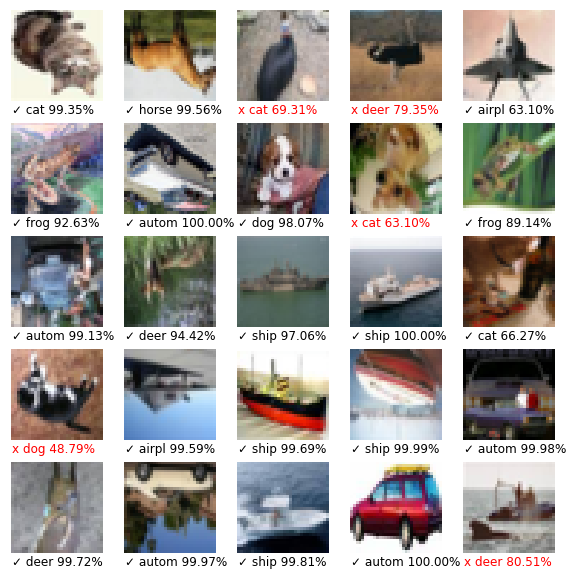

1563/1562 [==============================] - 1117s - loss: 0.7652 - acc: 0.7838 - val_loss: 1.0850 - val_acc: 0.7225
Epoch 2/300
1562/1562 [============================>.] - ETA: 0s - loss: 0.7010 - acc: 0.8166

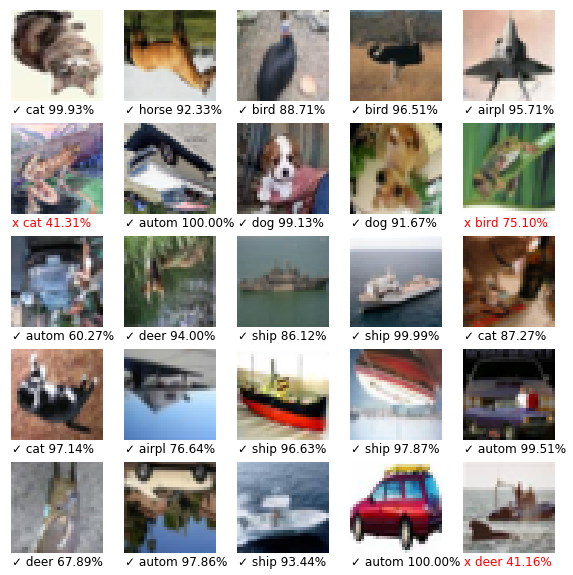

1563/1562 [==============================] - 1108s - loss: 0.7012 - acc: 0.8165 - val_loss: 0.9209 - val_acc: 0.7563
Epoch 3/300
1562/1562 [============================>.] - ETA: 0s - loss: 0.6909 - acc: 0.8296

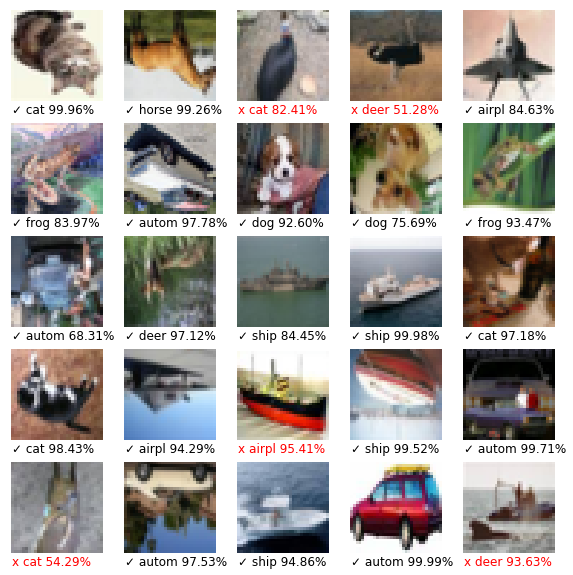

1563/1562 [==============================] - 1108s - loss: 0.6910 - acc: 0.8296 - val_loss: 1.1214 - val_acc: 0.7134
Epoch 4/300
1562/1562 [============================>.] - ETA: 0s - loss: 0.4006 - acc: 0.9363

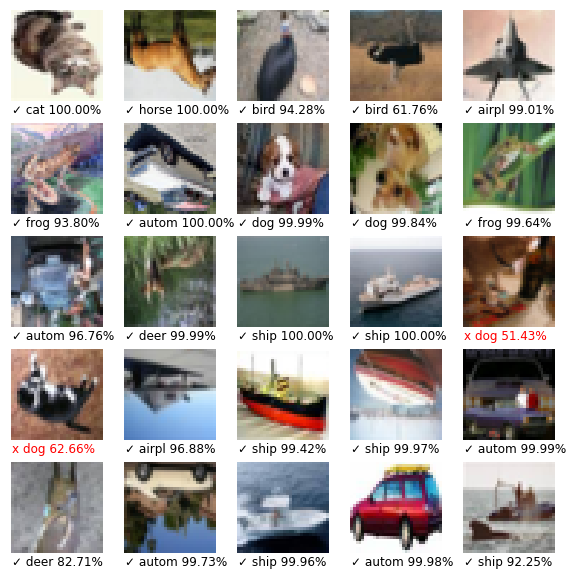

1563/1562 [==============================] - 1110s - loss: 0.4005 - acc: 0.9363 - val_loss: 0.5308 - val_acc: 0.8933
Epoch 38/300
1562/1562 [============================>.] - ETA: 0s - loss: 0.3919 - acc: 0.9390

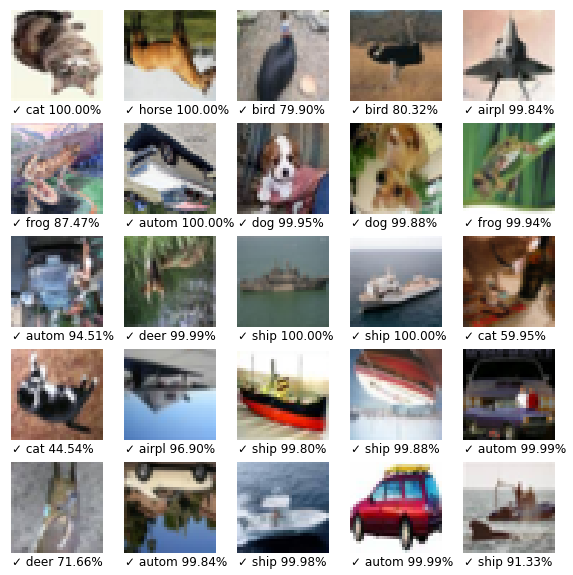

1563/1562 [==============================] - 1110s - loss: 0.3920 - acc: 0.9390 - val_loss: 0.5232 - val_acc: 0.8990
Epoch 39/300
1562/1562 [============================>.] - ETA: 0s - loss: 0.3924 - acc: 0.9378

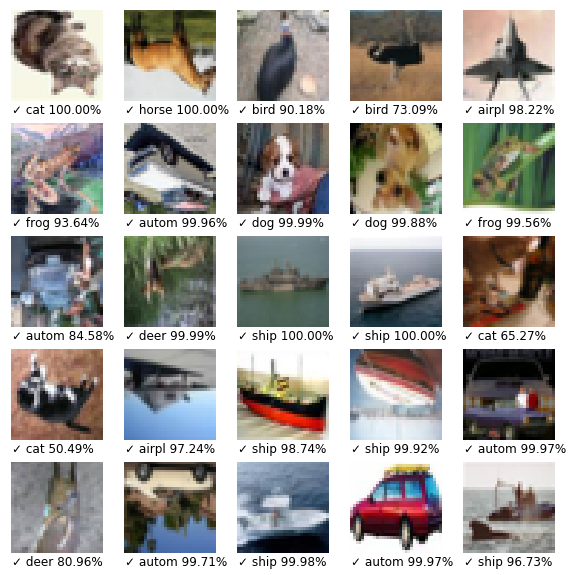

1563/1562 [==============================] - 1110s - loss: 0.3925 - acc: 0.9377 - val_loss: 0.5260 - val_acc: 0.8883
Epoch 40/300
 809/1562 [==============>...............] - ETA: 526s - loss: 0.3892 - acc: 0.9379

In [ ]:
model.fit_generator(
    train_gen,
    steps_per_epoch=train_gen.n/train_gen.batch_size,
    epochs=300,
    verbose=True,
    validation_data=val_gen,
    validation_steps=50,
    callbacks=[
        # I <3 keras callbacks
        
        # Give us visual feedback on our progress
        PredictPlot(X_val, y_val),
        
        # When it's stopped improving, lower the learning rate to fine tuning it
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4),
        
        # Then if that doesn't work, stop early
        # (this gives you a boost but is "cheating" if you do it on test data)
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=6),
        
        # So we can resume
        keras.callbacks.ModelCheckpoint('./checkpoint.h5'),
        keras.callbacks.CSVLogger('./log.csv'),
        
        # Html progress bar
#         TQDMNotebookCallback(leave_inner=True),
    ]
)

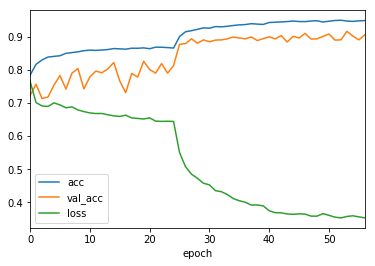

In [36]:
# Notice the jumps when the learning rate was automatically dropped
# And the plateau where early stopping activated
history = pd.DataFrame(model.history.history)
history.index.name = 'epoch'
history[['acc','val_acc','loss']].plot()

In [37]:
score = model.evaluate_generator(
    val_gen, 
    steps=50
)
score = dict(zip(model.metrics_names, score))
print('acc',score['acc'])

acc 1.0


In [38]:
model.save('densenet_cifar1_augmented_mjc_%s2.2.h5'%score['acc'])

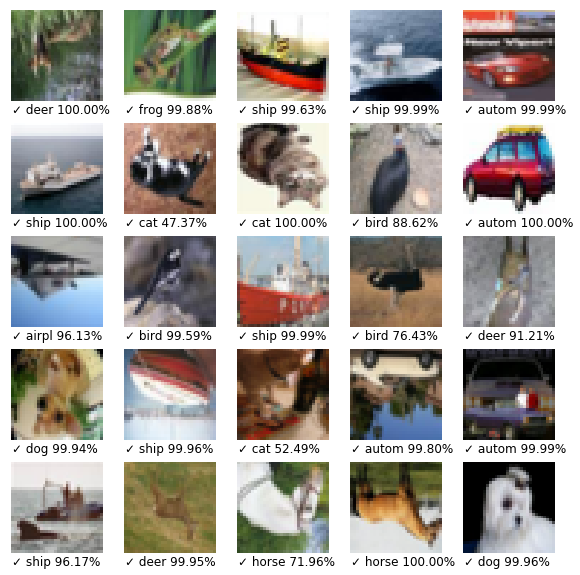

In [39]:
X,y=next(val_gen)
y_pred = model.predict(X)
plot_predictions(X,y,y_pred)

# Now how does the augmented model do on normal data?

In [ ]:
# No time to train for 300 epochs
# So lets switch to one prepared earlier

# load a pretrained densenet model from https://github.com/robertomest/convnet-study
model = keras.models.model_from_json(
    open('pretrained_models/densenet_cifar10_robertomest/densenet.json')
    .read())
model.load_weights(
    './pretrained_models/densenet_cifar10_robertomest/densenet_aug.h5')

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [40]:
datagen = ImageDataGenerator(
)
datagen.fit(X_val, seed=seed)
val_gen = datagen.flow(X_val, y_val, batch_size=batch_size, seed=seed)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size, seed=seed)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size, seed=seed)

In [50]:
score = model.evaluate_generator(
    test_gen, 
    steps=test_gen.n/batch_size
)
score = dict(zip(model.metrics_names, score))
print('acc',score['acc'])

acc 0.912625


# I <3 graphs

In [53]:
X=[]
y=[]
for i in tqdm(range(int(test_gen.n/batch_size))):
    X_batch,y_batch=next(val_gen)
    y.append(y_batch)
    X.append(X_batch)
X=np.concatenate(X)
y=np.concatenate(y)
y_pred = model.predict(X)
X.shape, y.shape, y_pred.shape

((8000, 32, 32, 3), (8000, 10), (8000, 10))

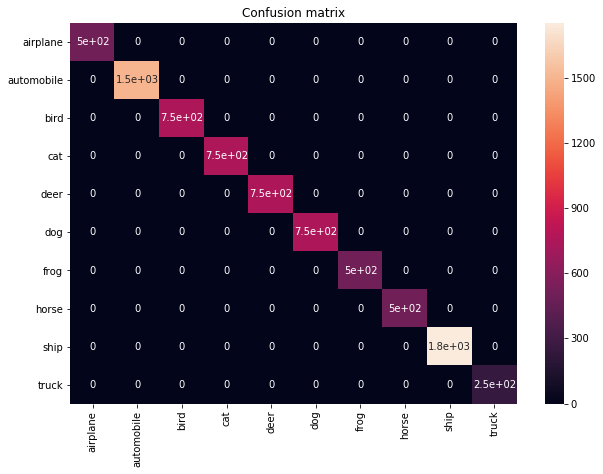

In [54]:
import sklearn
confusion_matrix = sklearn.metrics.confusion_matrix(
    y.argmax(-1), y_pred.argmax(-1), labels=range(len(label_names)))
confusion_matrix = pd.DataFrame(confusion_matrix, columns=label_names, index=label_names)

plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(confusion_matrix, annot=True)

In [55]:
import sklearn
report = sklearn.metrics.classification_report(y.argmax(-1), y_pred.argmax(-1), target_names=label_names)
print(report)

             precision    recall  f1-score   support

   airplane       1.00      1.00      1.00       500
 automobile       1.00      1.00      1.00      1500
       bird       1.00      1.00      1.00       750
        cat       1.00      1.00      1.00       750
       deer       1.00      1.00      1.00       750
        dog       1.00      1.00      1.00       750
       frog       1.00      1.00      1.00       500
      horse       1.00      1.00      1.00       500
       ship       1.00      1.00      1.00      1750
      truck       1.00      1.00      1.00       250

avg / total       1.00      1.00      1.00      8000



In [56]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


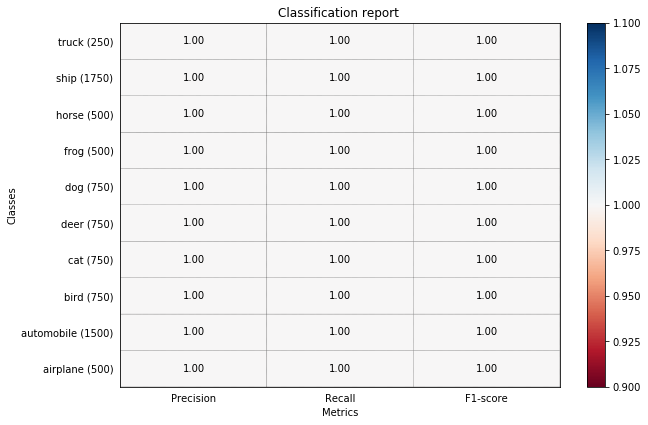

In [57]:
plot_classification_report(report)

# Real world examples

Building detection model I did with satellite analytics startup ![ovass.com](http://www.ovass.com/wp-content/uploads/2015/11/ovass-logo-retina.png)

Model
- UNet based model 
- Jacard loss for unbalanced data
- Trained for 28+ hours 
- Using RGB 60cm imagery from 5 cities. 
- Use of data augumentation (rotate, zoom, channel_shift)
- Pixel-wise segmentation, of [background, edge, building] 
    - the edge class helps it draw accurate edges and convert the output to building polygons

Result: f1 score of **0.93** (pixel-wise)

Training images:



1 epochs (some pretraining):
![](images/1e.png)

9 epochs:
![](images/9e.png)

18 epochs:
![](images/18e.png)

27+ epochs:
![](images/27e.png)





![](images/spookfish.png)
![](images/spookfish_building_detection.png)

# Random

## adversarial examples
- adversarial examples https://guillaumebrg.wordpress.com/2016/03/26/dogs-vs-cats-kaggle-submission-models-fusion-attempt-adversarial-examples/
    - Kaggle: https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack
![adv_examples](https://blog.openai.com/content/images/2017/02/adversarial_img_1.png)
- https://blog.openai.com/robust-adversarial-inputs/
- usage: fooling face recognition by wearing infrared makeup, fooling self driving cars etc

## Hate for keras and my brush with the stars :O

- fchollet can be a bit rude https://github.com/fchollet/keras/issues/5299#issuecomment-279163646
- some people hate keras https://www.reddit.com/r/MachineLearning/comments/5zd3ju/n_introducing_keras_2/?utm_term=589ab872-fde7-4c3e-9852-c284ab9e7b0d&utm_medium=search&utm_source=reddit&utm_name=MachineLearning&utm_content=1
- he said 4 letters to me
    - https://github.com/fchollet/keras/pulls?utf8=%E2%9C%93&q=%20is%3Apr%20author%3Awassname%20
        - https://github.com/fchollet/keras/pull/7623#pullrequestreview-55971168
        - https://github.com/fchollet/keras/pull/3751#issuecomment-248806505


In [ ]:
# code for an finding a simple adverserial example wander
datagen = ImageDataGenerator()
datagen.fit(X_val, seed=seed)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size, seed=seed)

# get image
X, y = next(train_gen)
X, y = next(train_gen)
y_pred = model.predict(X)
last_confidence = 1.0

# loop untill it thinks it's another class
while y_pred.argmax(-1)[0]==y.argmax(-1)[0]:

    # Add random noise
    X_noise = X + np.random.random((X.shape)) / 20
    y_pred = model.predict(X_noise)

    # If this round of noise confused it, then  keep it
    conf = y_pred.max(-1)[0]
    if conf < last_confidence:
        last_confidence = conf
        X = X_noise
        
        # plot
        fig = plt.figure(figsize=(6, 2))
        ax = plt.subplot(132)
        ax.set_title('image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(unpreprocess_data(X_noise*1)[0])

        ax = plt.subplot(133)
        ax.set_title('noise')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(unpreprocess_data(X_noise*1-X*1)[0])

        ax = plt.subplot(131)
        ax.set_title('classes')
        ax.bar(range(len(label_names)), height=y_pred[0], tick_label=label_names)
        ax.set_xticklabels(label_names, rotation='vertical', fontsize=12)
        ax.set_ylim([0, 1])
        plt.show()
